In [27]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [28]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to /Users/yunlingge/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yunlingge/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yunlingge/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yunlingge/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [29]:
import spacy
import re 
import string

In [30]:
#from bs4 import BeautifulSoup
from wordcloud import WordCloud

In [31]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [32]:
# data = pd.read_csv('/content/drive/MyDrive/Ironhack/Final-Project/file.csv')
data = pd.read_csv('../data/raw data/file.csv')

In [33]:
data.head()

Unnamed: 0                                             tweets   labels
0           0  ChatGPT: Optimizing Language Models for Dialog...  neutral
1           1  Try talking with ChatGPT, our new AI system wh...     good
2           2  ChatGPT: Optimizing Language Models for Dialog...  neutral
3           3  THRILLED to share that ChatGPT, our new model ...     good
4           4  As of 2 minutes ago, @OpenAI released their ne...      bad

In [34]:
data = data.drop(['Unnamed: 0'],axis=1)
data.head()

tweets   labels
0  ChatGPT: Optimizing Language Models for Dialog...  neutral
1  Try talking with ChatGPT, our new AI system wh...     good
2  ChatGPT: Optimizing Language Models for Dialog...  neutral
3  THRILLED to share that ChatGPT, our new model ...     good
4  As of 2 minutes ago, @OpenAI released their ne...      bad

In [35]:
#df is a copy of original dataset for EDA part
df = data.copy()
df.head()

tweets   labels
0  ChatGPT: Optimizing Language Models for Dialog...  neutral
1  Try talking with ChatGPT, our new AI system wh...     good
2  ChatGPT: Optimizing Language Models for Dialog...  neutral
3  THRILLED to share that ChatGPT, our new model ...     good
4  As of 2 minutes ago, @OpenAI released their ne...      bad

# EDA before text cleaning

In [36]:
df.describe()

tweets  labels
count    219294  219294
unique   217622       3
top     ChatGPT     bad
freq        122  107796

In [37]:
df.shape

(219294, 2)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219294 entries, 0 to 219293
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tweets  219294 non-null  object
 1   labels  219294 non-null  object
dtypes: object(2)
memory usage: 3.3+ MB


In [39]:
#get the length of each review
df['length_before_clean'] = list(map(lambda x: len(str(x).split()), df['tweets']))

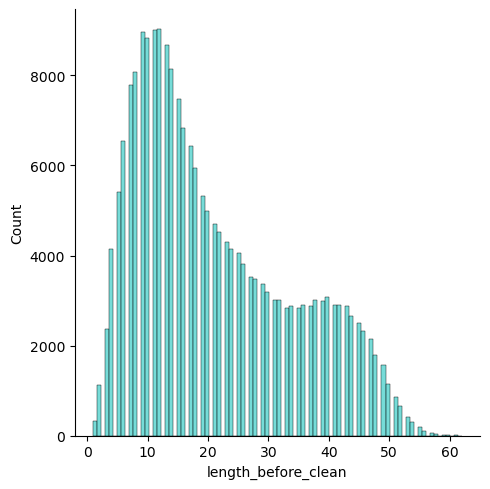

In [40]:
sns.displot(df['length_before_clean'],color='mediumturquoise')

In [41]:
df['length_before_clean'].describe()

count    219294.000000
mean         21.160137
std          12.984769
min           1.000000
25%          11.000000
50%          18.000000
75%          31.000000
max          62.000000
Name: length_before_clean, dtype: float64

In [42]:
df.isna().sum()

tweets                 0
labels                 0
length_before_clean    0
dtype: int64

In [43]:
#check the distribution of tweets
label_count = df.groupby('labels').count()['tweets'].reset_index().sort_values(by='tweets',ascending=False)
label_count.style.background_gradient(cmap='Reds')

<Axes: xlabel='labels', ylabel='count'>

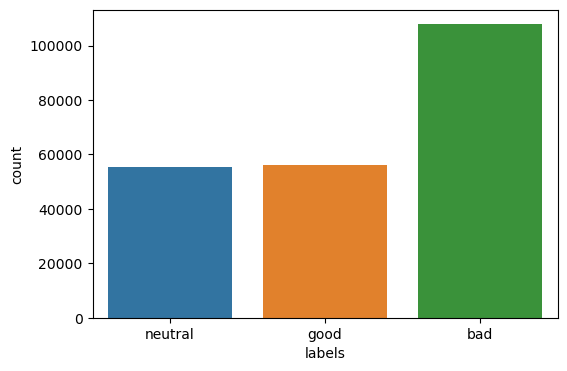

In [44]:
plt.figure(figsize=(6,4))
sns.countplot(x='labels',data=df)

In [45]:
df['labels'].value_counts(normalize=True)

bad        0.491559
good       0.255415
neutral    0.253026
Name: labels, dtype: float64

- Since there is class imbalance, I will do downsampling before train models

(0.0, 75.0)

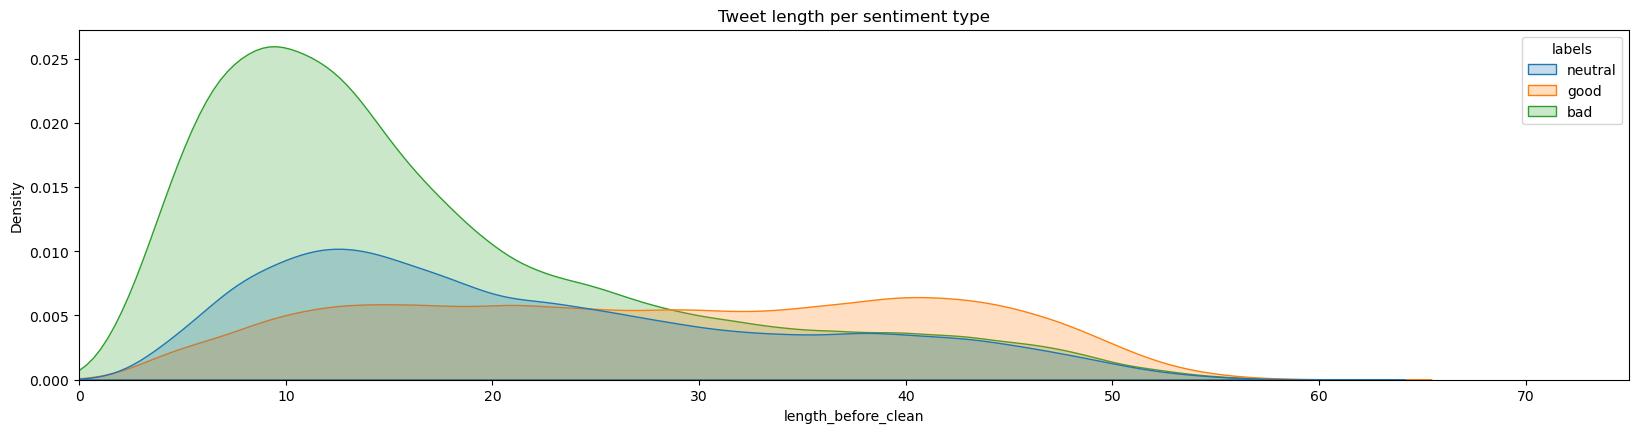

In [73]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
sns.kdeplot(x=df['length_before_clean'],hue=df['labels'],shade=True)
plt.title('Tweet length per sentiment type')
plt.xlim(0,75)

### Wordcloud before text cleaning

In [46]:
#concentrate the text review data
reviews = ' '.join(df['tweets'])

In [47]:
# how many words in my original dataset 
len(reviews)

31954118

In [48]:
#create the word cloud image
word_cloud = WordCloud(background_color='white',
                       stopwords=ENGLISH_STOP_WORDS,
                       width=800,
                       height=400
                       )

In [49]:
#generate the word cloud using the review data
word_cloud.generate(reviews)

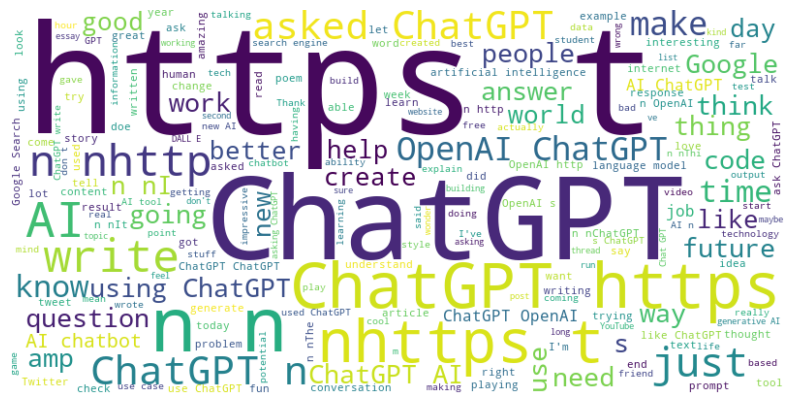

In [50]:
#display the word cloud for the whole original tweets
plt.rcParams['figure.figsize']=(10,6)
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# Text cleaning

##  Basic cleaning

- change all words to lower case
- remove all web link
- remove all punctuation
- remove 'chatgpt'

In [51]:
def clean_up(text):
    text = str(text).lower()
    text = text.replace('\\n','')
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'\W+',' ',text)
    text = re.sub(r'\s+',' ',text)
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('<.*?>+', '', text)
    text = text.replace("'s", '')
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[0-9]','',text)
    text = text.replace('chatgpt','')
    text = re.sub(r'\b\w*(\w)\1+\w*\b','',text) #replace words with repeated charatecers by ''
    text = re.sub(r'\d+','',text) # replace one or more digits by ''
    return text

In [52]:
df['tweets_v1'] = df['tweets'].apply(clean_up)

In [53]:
df

tweets   labels  \
0       ChatGPT: Optimizing Language Models for Dialog...  neutral   
1       Try talking with ChatGPT, our new AI system wh...     good   
2       ChatGPT: Optimizing Language Models for Dialog...  neutral   
3       THRILLED to share that ChatGPT, our new model ...     good   
4       As of 2 minutes ago, @OpenAI released their ne...      bad   
...                                                   ...      ...   
219289  Other Software Projects Are Now Trying to Repl...      bad   
219290  I asked #ChatGPT to write a #NYE Joke for SEOs...     good   
219291  chatgpt is being disassembled until it can onl...      bad   
219292  2023 predictions by #chatGPT. Nothing really s...      bad   
219293   From ChatGPT, neat stuff https://t.co/qjjUF2Z2m0  neutral   

        length_before_clean                                          tweets_v1  
0                         8     optimizing language models for dialogue openai  
1                        21  try talking with  our new ai system which is o...  
2                        26   optimizing language models for dialogue ai ma...  
3                        22   to share that  our new model optimized for di...  
4                        20  as of  minutes ago openai released their new  ...  
...                     ...                                                ...  
219289                   10  other software projects are now trying to repl...  
219290                   42  i asked  to write a nye joke for seos and it d...  
219291                    9                       is being  until it can only   
219292                   27   predictions by  nothing  specific just some t...  
219293                    5                                       from  neat    

[219294 rows x 4 columns]

#### check the word frequency after the basic text cleaning

In [54]:
wordfreq = {} # A dictionary to hold as keys every single word, and the value is how many times appears the word.
for sentence in df['tweets_v1']:
    #words = sentence.split() # List of words in a given review.
    tokens = nltk.word_tokenize(sentence) # To get the words, it can be also done with sentence.split()
    for word in tokens:
        if ( word not in wordfreq.keys() ):
            wordfreq[word] = 1 # We initialize the corresponding counter
        else:
            wordfreq[word] += 1 # We increase the corresponding counter

In [55]:
wordfreq_df = pd.DataFrame.from_dict(wordfreq, orient='index',columns=['common_words'])

In [56]:
wordfreq_df = pd.DataFrame.from_dict(wordfreq, orient="index").reset_index()
wordfreq_df.columns = ['common_words','count']
wordfreq_df.head()

common_words  count
0   optimizing    292
1     language   4968
2       models   2303
3          for  50086
4     dialogue    791

In [57]:
wordfreq_df.shape

(74246, 2)

In [58]:
freq = wordfreq_df.sort_values('count',ascending = False).head(20)
freq.style.background_gradient(cmap='Blues')

- as we can see from the above top 20 common words, most of them are meaningless words. Thus, i will remove these stop words.

## Text tokenization

In [59]:
df['tokens'] = df['tweets_v1'].apply(lambda x: str(x).split())

In [60]:
df['tokens']

0         [optimizing, language, models, for, dialogue, ...
1         [try, talking, with, our, new, ai, system, whi...
2         [optimizing, language, models, for, dialogue, ...
3         [to, share, that, our, new, model, optimized, ...
4         [as, of, minutes, ago, openai, released, their...
                                ...                        
219289    [other, software, projects, are, now, trying, ...
219290    [i, asked, to, write, a, nye, joke, for, seos,...
219291                    [is, being, until, it, can, only]
219292    [predictions, by, nothing, specific, just, som...
219293                                         [from, neat]
Name: tokens, Length: 219294, dtype: object

## Remove stopwords

In [61]:
stop_words = list(stopwords.words('english')) 

In [62]:
def remove_stop_words(text):
    tokenized_without_stop_words = []
    for word in text:
        if word not in stop_words:
            tokenized_without_stop_words.append(word)
    return tokenized_without_stop_words

In [63]:
df['tweets_v2'] = df['tokens'].apply(remove_stop_words)

## Remove single characters

In [64]:
def remove_single_char_func(text, threshold=1):
    text_without_singlechar = []
    threshold = threshold
    for word in text:
        if len(word) > threshold:
            text_without_singlechar.append(word)
    return text_without_singlechar

In [65]:
 df['tweets_v3'] = df['tweets_v2'].apply(remove_single_char_func)

## Lemmatization

In [66]:
lemm = WordNetLemmatizer()
def text_lemmatize(text):
    text_lemm = []
    for word in text:
        text_lemm.append(lemm.lemmatize(word))
    return text_lemm

In [67]:
df['tweets_v4'] = df['tweets_v3'].apply(text_lemmatize)

#### apply remove_single_char_func again

In [68]:
df['tweets_v4'] = df['tweets_v4'].apply(remove_single_char_func)

-  i was going to use both stemming and lemmatization methods, however, i found that many words are meaningless after using stemming. Thus, in the end, i only used Lemmatization method

In [69]:
#convert the list in the column'tweets_v4' into str
df['tweets_v4_str'] = df['tweets_v4'].apply(lambda x: ' '.join(map(str,x)))

In [70]:
df['length_after_clean'] = df['tweets_v4'].apply(lambda x: len(x))
df.head()

tweets   labels  \
0  ChatGPT: Optimizing Language Models for Dialog...  neutral   
1  Try talking with ChatGPT, our new AI system wh...     good   
2  ChatGPT: Optimizing Language Models for Dialog...  neutral   
3  THRILLED to share that ChatGPT, our new model ...     good   
4  As of 2 minutes ago, @OpenAI released their ne...      bad   

   length_before_clean                                          tweets_v1  \
0                    8     optimizing language models for dialogue openai   
1                   21  try talking with  our new ai system which is o...   
2                   26   optimizing language models for dialogue ai ma...   
3                   22   to share that  our new model optimized for di...   
4                   20  as of  minutes ago openai released their new  ...   

                                              tokens  \
0  [optimizing, language, models, for, dialogue, ...   
1  [try, talking, with, our, new, ai, system, whi...   
2  [optimizing, language, models, for, dialogue, ...   
3  [to, share, that, our, new, model, optimized, ...   
4  [as, of, minutes, ago, openai, released, their...   

                                           tweets_v2  \
0   [optimizing, language, models, dialogue, openai]   
1  [try, talking, new, ai, system, optimized, dia...   
2  [optimizing, language, models, dialogue, ai, m...   
3  [share, new, model, optimized, dialog, public,...   
4  [minutes, ago, openai, released, new, use, right]   

                                           tweets_v3  \
0   [optimizing, language, models, dialogue, openai]   
1  [try, talking, new, ai, system, optimized, dia...   
2  [optimizing, language, models, dialogue, ai, m...   
3  [share, new, model, optimized, dialog, public,...   
4  [minutes, ago, openai, released, new, use, right]   

                                           tweets_v4  \
0    [optimizing, language, model, dialogue, openai]   
1  [try, talking, new, ai, system, optimized, dia...   
2  [optimizing, language, model, dialogue, ai, ma...   
3  [share, new, model, optimized, dialog, public,...   
4   [minute, ago, openai, released, new, use, right]   

                                       tweets_v4_str  length_after_clean  
0          optimizing language model dialogue openai                   5  
1  try talking new ai system optimized dialogue h...                   9  
2  optimizing language model dialogue ai machinel...                  19  
3   share new model optimized dialog public everyone                   7  
4           minute ago openai released new use right                   7

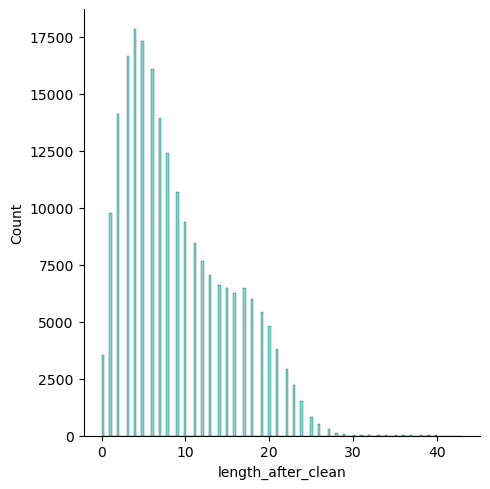

In [45]:
sns.displot(df['length_after_clean'],color ='mediumturquoise')

In [46]:
df['length_after_clean'].describe()

count    219294.000000
mean          9.100897
std           6.232954
min           0.000000
25%           4.000000
50%           8.000000
75%          13.000000
max          43.000000
Name: length_after_clean, dtype: float64

(0.0, 75.0)

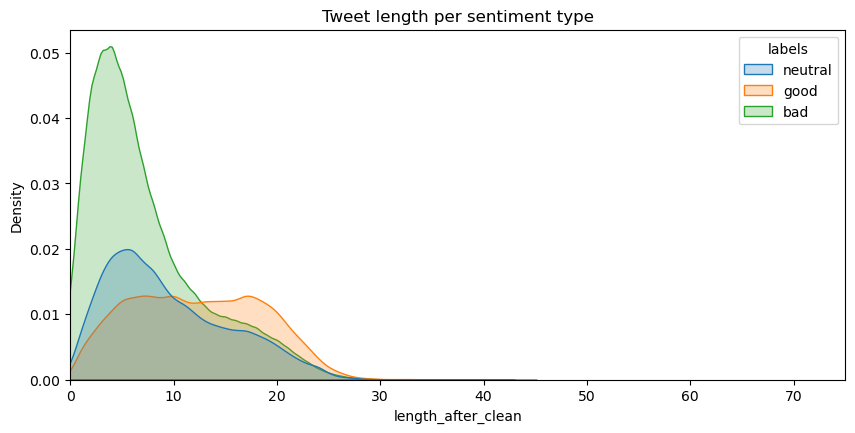

In [74]:
plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
sns.kdeplot(x=df['length_after_clean'],hue=df['labels'],shade=True)
plt.title('Tweet length per sentiment type')
plt.xlim(0,75)

## Save a new dataset after cleaning

In [47]:
df_cleaned = df.drop(
    ['length_before_clean',
    'tweets_v1',
    'tokens',
    'tweets_v2',
    'tweets_v3',
    'tweets_v4',
    'length_after_clean',
    'tweets'],axis=1)

In [48]:
df_cleaned.columns = ['labels','tweets_cleaned']

In [49]:
df_cleaned.head()

labels                                     tweets_cleaned
0  neutral          optimizing language model dialogue openai
1     good  try talking new ai system optimized dialogue h...
2  neutral  optimizing language model dialogue ai machinel...
3     good   share new model optimized dialog public everyone
4      bad           minute ago openai released new use right

In [50]:
df_cleaned.isna().sum()

labels            0
tweets_cleaned    0
dtype: int64

In [51]:
df_cleaned[df_cleaned.tweets_cleaned == ""]

labels tweets_cleaned
45          bad               
62          bad               
96         good               
370         bad               
471        good               
...         ...            ...
218900  neutral               
218938      bad               
218967      bad               
219111      bad               
219291      bad               

[3530 rows x 2 columns]

In [52]:
df_cleaned.drop(df_cleaned[df_cleaned.tweets_cleaned == ""].index,inplace=True)

In [53]:
df_cleaned.shape

(215764, 2)

In [54]:
df_cleaned.to_csv('../data/clean data/data_cleaned.csv',index=False)

# EDA after text cleaning

In [55]:
df2 = df_cleaned

In [56]:
df2.isna().sum()

labels            0
tweets_cleaned    0
dtype: int64

In [57]:
df2['tokens'] = df2['tweets_cleaned'].apply(lambda x: str(x).split())

In [58]:
df2.head()

labels                                     tweets_cleaned  \
0  neutral          optimizing language model dialogue openai   
1     good  try talking new ai system optimized dialogue h...   
2  neutral  optimizing language model dialogue ai machinel...   
3     good   share new model optimized dialog public everyone   
4      bad           minute ago openai released new use right   

                                              tokens  
0    [optimizing, language, model, dialogue, openai]  
1  [try, talking, new, ai, system, optimized, dia...  
2  [optimizing, language, model, dialogue, ai, ma...  
3  [share, new, model, optimized, dialog, public,...  
4   [minute, ago, openai, released, new, use, right]

In [59]:
# to check the wordcloud for the text cleaned
tweets_cleaned = ' '.join(df2['tweets_cleaned'])

In [60]:
#check the counts of the words after text processing
# before text cleaning, the number of text is 31954118.
len(tweets_cleaned)

13745925

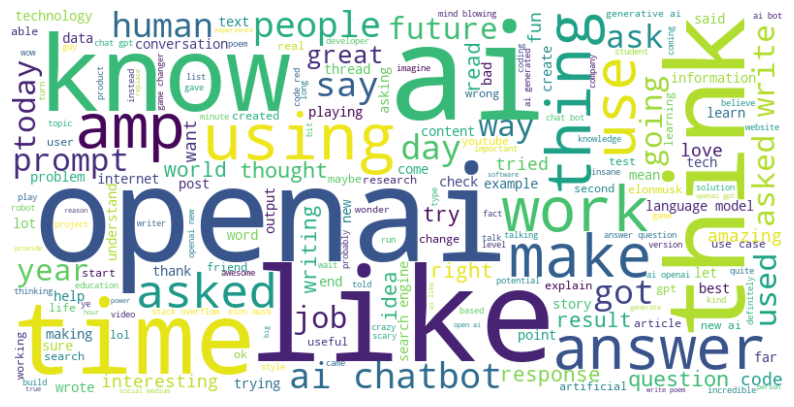

In [61]:
word_cloud.generate(tweets_cleaned)
plt.rcParams['figure.figsize']=(10,6)
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [62]:
from collections import Counter

In [112]:
#check the most common words after processing the tweets
top = Counter([item for sublist in df2['tokens'] for item in sublist])
top_600 = pd.DataFrame(top.most_common(600))
top_600 = top_600.iloc[0:,:]
top_600.columns = ['common_words','count']
top_600.style.background_gradient(cmap='Purples')

###  check the most frequent word in each sentiment

In [64]:
df_good = df2[df2['labels']=='good']
df_bad = df2[df2['labels']=='bad']
df_neutral = df2[df2['labels']=='neutral']

In [113]:
top_good = Counter([item for sublist in df_good['tokens'] for item in sublist])
top_good_ = pd.DataFrame(top_good.most_common(600))
top_good_.columns = ['common_words','count']
top_good_.style.background_gradient(cmap='Reds')

In [114]:
top_neutral = Counter([item for sublist in df_neutral['tokens'] for item in sublist])
top_ne_ = pd.DataFrame(top_neutral.most_common(600))
top_ne_.columns = ['common_words','count']
top_ne_.style.background_gradient(cmap='Greens')

In [115]:
top_bad = Counter([item for sublist in df_bad['tokens'] for item in sublist])
top_bad_ = pd.DataFrame(top_bad.most_common(600))
top_bad_.columns = ['common_words','count']
top_bad_.style.background_gradient(cmap='gist_yarg')

- As we can see from above, there are too many common words for all good,bad,neutral labels. I will remove some of them in order to have a better insights about what are the main frequent and unique words for each sentiment.

## Text preprocessing improvement

### Remove the most common words of all of the three labels
- in order to have a better insights about the unique common words in each sentiment

In [116]:
ls_good = top_good_['common_words'].values.tolist()
ls_ne = top_ne_['common_words'].values.tolist()
ls_bad =top_ne_['common_words'].values.tolist()

In [117]:
ls = list(set(ls_good + ls_ne + ls_bad))
len(ls)

671

In [70]:
ls_common = []
for word in ls:
    if word in ls_good and word in ls_ne and word in ls_bad:
        ls_common.append(word) 

In [71]:
len(ls_common)

529

- There are 868 most frequent common words in all three sentiment, i will remove them.

In [72]:
def remove_common_words(text):
    text_less_common = []
    for word in text:
        if word not in ls_common:
            text_less_common.append(word)
    return text_less_common

In [73]:
df2['tokens_less_common'] = df2['tokens'].apply(remove_common_words)

In [74]:
# in order to generate wordcloud, i need to gene
df2['tokens_less_common_str'] = df2['tokens_less_common'].apply(lambda x: ' '.join(map(str,x)))

In [75]:
df2

labels                                     tweets_cleaned  \
0       neutral          optimizing language model dialogue openai   
1          good  try talking new ai system optimized dialogue h...   
2       neutral  optimizing language model dialogue ai machinel...   
3          good   share new model optimized dialog public everyone   
4           bad           minute ago openai released new use right   
...         ...                                                ...   
219288  neutral                 sound like ai predict trend openai   
219289      bad                  software project trying replicate   
219290     good  asked write nye joke seos delivered seo make r...   
219292      bad  prediction nothing specific trend past year ar...   
219293  neutral                                               neat   

                                                   tokens  \
0         [optimizing, language, model, dialogue, openai]   
1       [try, talking, new, ai, system, optimized, dia...   
2       [optimizing, language, model, dialogue, ai, ma...   
3       [share, new, model, optimized, dialog, public,...   
4        [minute, ago, openai, released, new, use, right]   
...                                                   ...   
219288          [sound, like, ai, predict, trend, openai]   
219289             [software, project, trying, replicate]   
219290  [asked, write, nye, joke, seos, delivered, seo...   
219292  [prediction, nothing, specific, trend, past, y...   
219293                                             [neat]   

                                       tokens_less_common  \
0                                            [optimizing]   
1                                             [optimized]   
2       [optimizing, identified, digested, granola, dr...   
3                                     [optimized, dialog]   
4                                                      []   
...                                                   ...   
219288                                          [predict]   
219289                                        [replicate]   
219290  [nye, seos, delivered, resolution, eat, health...   
219292                                       [prediction]   
219293                                             [neat]   

                                   tokens_less_common_str  
0                                              optimizing  
1                                               optimized  
2       optimizing identified digested granola driven ...  
3                                        optimized dialog  
4                                                          
...                                                   ...  
219288                                            predict  
219289                                          replicate  
219290  nye seos delivered resolution eat healthier ra...  
219292                                         prediction  
219293                                               neat  

[215764 rows x 5 columns]

In [76]:
df2.isna().sum()

labels                    0
tweets_cleaned            0
tokens                    0
tokens_less_common        0
tokens_less_common_str    0
dtype: int64

In [77]:
df2[df2.tokens_less_common_str == '']

labels                                     tweets_cleaned  \
4           bad           minute ago openai released new use right   
6           bad           minute ago openai released new use right   
41         good  another new release available anyone try right...   
42      neutral                                  ok openai already   
54          bad                           english writing going go   
...         ...                                                ...   
219246      bad  one first thing said trying lot student never ...   
219251     good                      excited could save time legal   
219256  neutral                                            let try   
219267      bad                          mean robot coming job via   
219279      bad                          mean robot coming job via   

                                                   tokens tokens_less_common  \
4        [minute, ago, openai, released, new, use, right]                 []   
6        [minute, ago, openai, released, new, use, right]                 []   
41      [another, new, release, available, anyone, try...                 []   
42                                  [ok, openai, already]                 []   
54                          [english, writing, going, go]                 []   
...                                                   ...                ...   
219246  [one, first, thing, said, trying, lot, student...                 []   
219251                [excited, could, save, time, legal]                 []   
219256                                         [let, try]                 []   
219267                    [mean, robot, coming, job, via]                 []   
219279                    [mean, robot, coming, job, via]                 []   

       tokens_less_common_str  
4                              
6                              
41                             
42                             
54                             
...                       ...  
219246                         
219251                         
219256                         
219267                         
219279                         

[23004 rows x 5 columns]

In [78]:
df2.drop(df2[df2.tokens_less_common_str == ''].index,inplace=True)

In [79]:
df2.shape

(192760, 5)

In [80]:
df_cleaned_v2 = df2.drop(['tweets_cleaned','tokens','tokens_less_common'],axis=1)

In [81]:
df_cleaned_v2.columns =['labels','tweets_new']

In [82]:
df_cleaned_v2.shape

(192760, 2)

In [83]:
df_cleaned_v2.isna().sum()

labels        0
tweets_new    0
dtype: int64

# EDA after removing the most common words in each sentiment
- removing the most common words (851) which exist in all the three sentiment

In [84]:
df3 = df_cleaned_v2
df3.head()

labels                                         tweets_new
0  neutral                                         optimizing
1     good                                          optimized
2  neutral  optimizing identified digested granola driven ...
3     good                                   optimized dialog
5     good                                          optimized

In [85]:
df3.isna().sum()

labels        0
tweets_new    0
dtype: int64

In [86]:
df3.shape

(192760, 2)

In [87]:
df3['tokens'] = df3['tweets_new'].apply(lambda x: str(x).split())

In [88]:
df3.head()

labels                                         tweets_new  \
0  neutral                                         optimizing   
1     good                                          optimized   
2  neutral  optimizing identified digested granola driven ...   
3     good                                   optimized dialog   
5     good                                          optimized   

                                              tokens  
0                                       [optimizing]  
1                                        [optimized]  
2  [optimizing, identified, digested, granola, dr...  
3                                [optimized, dialog]  
5                                        [optimized]

In [89]:
df3['length_after_finalclean'] = df3['tokens'].apply(lambda x: len(x))
df3.head()

labels                                         tweets_new  \
0  neutral                                         optimizing   
1     good                                          optimized   
2  neutral  optimizing identified digested granola driven ...   
3     good                                   optimized dialog   
5     good                                          optimized   

                                              tokens  length_after_finalclean  
0                                       [optimizing]                        1  
1                                        [optimized]                        1  
2  [optimizing, identified, digested, granola, dr...                        6  
3                                [optimized, dialog]                        2  
5                                        [optimized]                        1

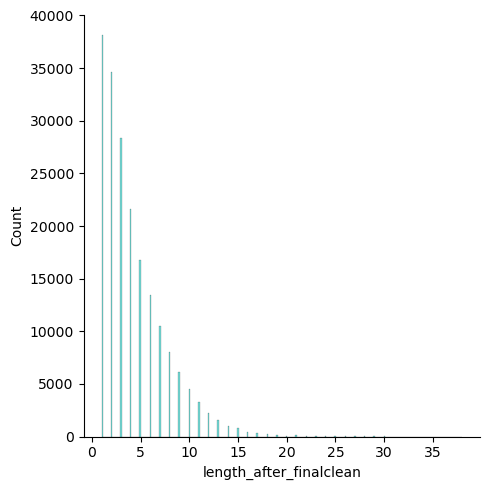

In [90]:
sns.displot(df3['length_after_finalclean'],color ='mediumturquoise')

In [91]:
df3['length_after_finalclean'].describe()

count    192760.000000
mean          4.264676
std           3.308279
min           1.000000
25%           2.000000
50%           3.000000
75%           6.000000
max          38.000000
Name: length_after_finalclean, dtype: float64

#### Wordcloud for the whole text after removing common words

In [92]:
comments = ' '.join(df3['tweets_new'])

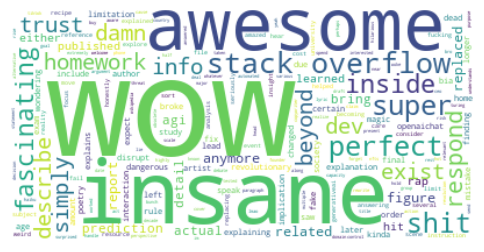

In [93]:
wordcloud2 = WordCloud(background_color="white").generate(comments)
plt.rcParams['figure.figsize']=(6,6)
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.show()

In [94]:
good = df3[df3['labels']=='good']
bad  = df3[df3['labels']=='bad']
neutral = df3[df3['labels']=='neutral']

#### Wordcloud for  'good'

In [95]:
tweets_good = ' '.join(good['tweets_new'])

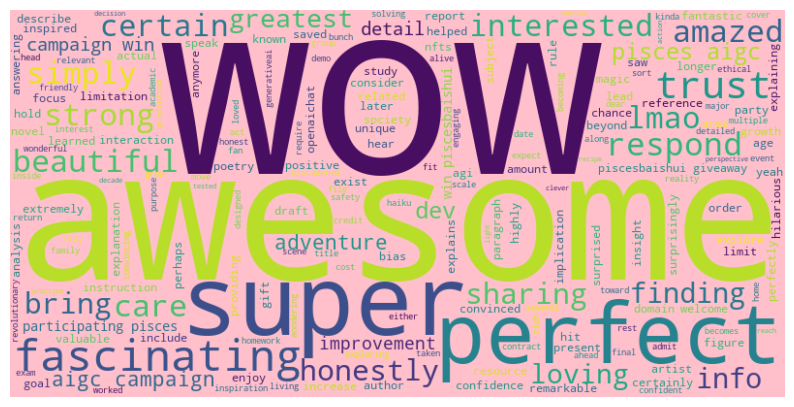

In [96]:
wordcloud_good = WordCloud(background_color="pink",width=800,
                       height=400).generate(tweets_good)
plt.rcParams['figure.figsize']=(10,6)
plt.imshow(wordcloud_good, interpolation="bilinear")
plt.axis("off")
plt.show()

In [97]:
tweets_neutral = ' '.join(neutral['tweets_new'])

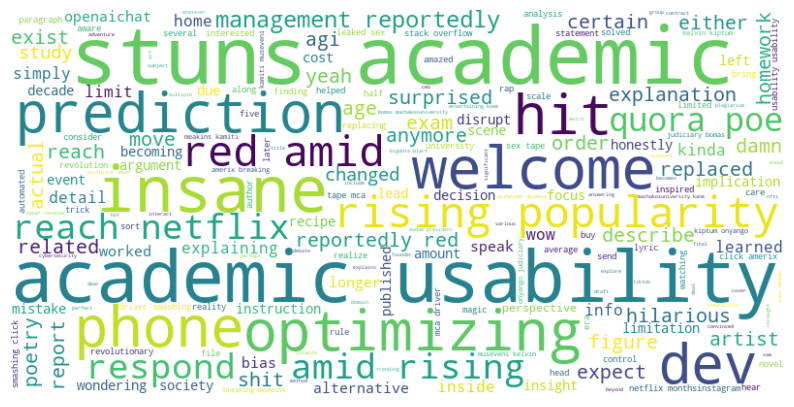

In [99]:
wordcloud_ne = WordCloud(background_color="white",width=800,
                       height=400).generate(tweets_neutral)
plt.rcParams['figure.figsize']=(10,6)
plt.imshow(wordcloud_ne, interpolation="bilinear")
plt.axis("off")
plt.show()

In [100]:
tweets_bad = ' '.join(bad['tweets_new'])

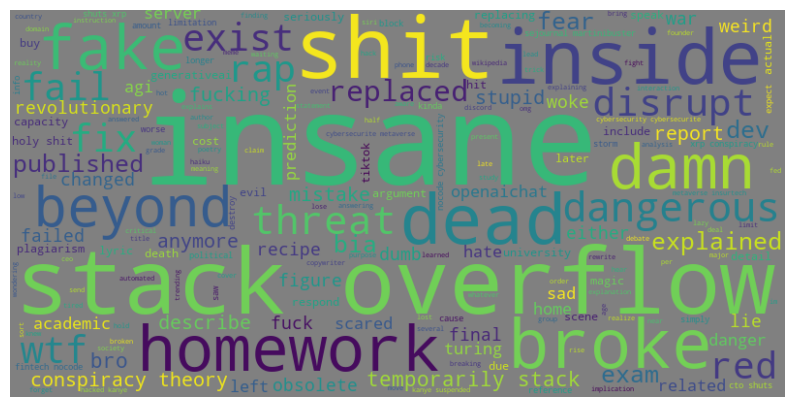

In [101]:
wordcloud_bad = WordCloud(background_color="grey",width=800,
                       height=400).generate(tweets_bad)
plt.rcParams['figure.figsize']=(10,6)
plt.imshow(wordcloud_bad, interpolation="bilinear")
plt.axis("off")
plt.show()

## Plot top 20 most frequent words

#### Whole text

In [102]:
top2 = Counter([item for sublist in df3['tokens'] for item in sublist])
top_20 = pd.DataFrame(top2.most_common(20))
top_20 = top_20.iloc[0:,:]
top_20.columns = ['common_words','count']
top_20.style.background_gradient(cmap='Purples')

In [103]:
import plotly.express as px
fig = px.treemap(top_20, path=['common_words'], values='count',title='Tree of Most Common Words')
fig.show()

#### Good

In [104]:
top_good_2 = Counter([item for sublist in good['tokens'] for item in sublist])
top_good_20 = pd.DataFrame(top_good_2.most_common(20))
top_good_20 = top_good_20.iloc[0:,:]
top_good_20.columns = ['common_words','count']
top_good_20.style.background_gradient(cmap='Reds')

In [105]:
fig_good = px.treemap(top_good_20, path=['common_words'], values='count',title='Top 20 Common Words In Good')
fig_good.show()

#### Neutral

In [110]:
top_ne_2 = Counter([item for sublist in neutral['tokens'] for item in sublist])
top_ne_20 = pd.DataFrame(top_ne_2.most_common(20))
top_ne_20 = top_ne_20.iloc[0:,:]
top_ne_20.columns = ['common_words','count']
top_ne_20.style.background_gradient(cmap='Greens')

In [111]:
fig_neutral = px.treemap(top_ne_20, path=['common_words'], values='count',title='Top 20 Common Words In Neutral')
fig_neutral.show()

#### Bad

In [108]:
top_bad_2 = Counter([item for sublist in bad['tokens'] for item in sublist])
top_bad_20 = pd.DataFrame(top_bad_2.most_common(20))
top_bad_20.columns = ['common_words','count']
top_bad_20.style.background_gradient(cmap='gist_yarg')

In [109]:
fig_bad = px.treemap(top_bad_20, path=['common_words'], values='count',title='Top 20 Common Words In Bad')
fig_bad.show()